In [2]:
%retina

UsageError: Line magic function `%retina` not found.


In [3]:
%matplotlib inline
from base import B2B, Forward, CrossDecomp, Backward, r_score
from sklearn.cross_decomposition import CCA, PLSRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import scale

import numpy as np
import matplotlib.pyplot as plt
from tqdm import trange
import pickle
import time
import submitit
import seaborn as sns
import pandas as pd
from tqdm import trange
from itertools import product

In [4]:
class Synthetic(object):
    def __init__(self,
                 dim_x=50,         # number of features
                 dim_y=30,         # number of sensors
                 nc=5,             # number of selected features
                 snr=1.0,          # signal-to-noise ratio
                 nonlinear=False):  # number of selected features
        
        # linear transformation
        self.F = np.random.randn(dim_x, dim_y) / np.sqrt(dim_x)

        # masking transformation
        self.E = np.array([0] * (dim_x - nc) + [1] * (nc))

        # features covariance
        self.cov_X = np.random.randn(dim_x, dim_x) / np.sqrt(dim_x)
        self.cov_X = self.cov_X @ self.cov_X.T
        
        # noise covariance
        self.cov_N = np.random.randn(dim_x, dim_x) / np.sqrt(dim_x)
        self.cov_N = self.cov_N @ self.cov_N.T
        
        self.dim_x = dim_x
        self.dim_y = dim_y
        self.nonlinear = nonlinear
        self.snr = snr

    def sample(self, n_samples=1000):
        X = np.random.multivariate_normal(np.zeros(self.dim_x),
                                          self.cov_X, n_samples)
        N = np.random.multivariate_normal(np.zeros(self.dim_x),
                                          self.cov_N, n_samples)

        # observed sensor data
        Y = (self.snr * X @ np.diag(self.E) + N) @ self.F

        if self.nonlinear:
            Y = 1. / (1. + np.exp(-Y))

        # return inputs, outputs, and solution
        return scale(X), scale(Y)


In [5]:
def GridCCA(n_components):
    grid = dict(n_components=np.unique(np.floor(np.linspace(1, n_components, 10)).astype(int)))
    return CrossDecomp(GridSearchCV(CCA(max_iter=1000), grid, cv=5))


def GridPLS(n_components):
    grid = dict(n_components=np.unique(np.floor(np.linspace(1, n_components, 10)).astype(int)))
    return CrossDecomp(GridSearchCV(PLSRegression(max_iter=1000), grid, cv=5))


models = {
    "B2B": B2B,
    "Forward": Forward,
    "Backward": Backward,
    "GridCCA": GridCCA,
    "GridPLS": GridPLS,
}

In [6]:
def run(args=dict()):
    import warnings
    warnings.filterwarnings("ignore")
    
    n_samples = args.get('n_samples', 1000)
    dim_x = args.get('dim_x', 100)
    dim_y = args.get('dim_y', 100)
    snr = args.get('snr', 1)
    nc = args.get('nc', 5)
    nonlinear = args.get('nonlinear', 0)
    n_seeds = args.get('n_seeds', 10)
        
    results = []

    for seed in range(n_seeds):
        np.random.seed(seed)

        # Make environment
        synthetic = Synthetic(dim_x, dim_y, nc,
                              snr, nonlinear)

        # Make data
        X_train, Y_train = synthetic.sample(n_samples)
        X_test, Y_test = synthetic.sample(n_samples * 10)

        for m, Model in models.items():
            
            model = Model(min(dim_x, dim_y)) if 'Grid' in m else Model()

            # fit model on training data
            start = time.time()
            model.fit(X_train, Y_train)
            duration = time.time() - start

            # Estimate effect from model parameters
            auc = roc_auc_score(synthetic.E, model.E_)

            # Estimate effect from prediction reliability on held-out data
            r_full = model.score(X_test, Y_test)
            r_ko = model.score_knockout(X_test, Y_test)

            r_delta = r_full - r_ko

            r_in = r_delta[synthetic.E==1].mean()
            r_out = r_delta[synthetic.E==0].mean()

            # Store results
            result = dict(dim_x=dim_x, dim_y=dim_y, nc=nc, snr=snr, 
                          nonlinear=nonlinear)
            result["model"] = m
            result["seed"] = seed
            result["r_in"] = r_in
            result["r_out"] = r_out
            result["auc"] = auc
            result['id'] = '_'.join(map(str, [dim_x, dim_y, nc, snr, nonlinear, 
                                              m, seed]))
            result['duration'] = duration
            print(result)
            results.append(result)
    return results

In [7]:
executor = submitit.AutoExecutor(folder='./synthetic_ng/')

In [8]:
executor.update_parameters(timeout_min=720, 
#                            partition='learnfair,uninterrupted,scavenge',
                           partition='priority',
                           comment='iclr',
                           constraint='pascal', cpus_per_task=12)

In [9]:
jobs = list()
# snrs = np.logspace(-3, 3, 10)
# dim_xs = np.logspace(1, 3, 10).astype(int)
# dim_ys = np.logspace(1, 3, 10).astype(int)
# ncs = np.logspace(0, 2, 10).astype(int)

snrs = np.logspace(-3, 1, 10)
dim_xs = np.logspace(1, 2, 10).astype(int)
dim_ys = np.logspace(1, 2, 6).astype(int)
ncs = np.logspace(0.5, 1.8, 10).astype(int)

# snrs = np.logspace(-3, 3, 3)
# dim_xs = np.logspace(1, 3, 3).astype(int)
# dim_ys = np.logspace(1, 3, 3).astype(int)
# ncs = np.logspace(0, 2, 3).astype(int)

print(snrs)
print(dim_xs)
print(dim_ys)
print(ncs)

all_args = list()
for snr, dim_x, dim_y, nc in product(snrs, dim_xs, dim_ys, ncs):
    if nc>=dim_x: continue
    args = dict(snr=snr, n_seeds=5,
                dim_x=dim_x, dim_y=dim_y, nc=nc)
    all_args.append([args,])

# for snr, dim_x, dim_y, nc in product(snrs, dim_xs, dim_ys, ncs):
#     if nc>=dim_x: continue
#     args = dict(snr=snr, n_seeds=5,
#                 dim_x=dim_x, dim_y=dim_y, nc=nc)
#     jobs.append([args,])
jobs = executor.map_array(run, *zip(*all_args))

[1.00000000e-03 2.78255940e-03 7.74263683e-03 2.15443469e-02
 5.99484250e-02 1.66810054e-01 4.64158883e-01 1.29154967e+00
 3.59381366e+00 1.00000000e+01]
[ 10  12  16  21  27  35  46  59  77 100]
[ 10  15  25  39  63 100]
[ 3  4  6  8 11 16 23 32 45 63]


In [245]:
[f'{snr:.3}' for snr in snrs]

['0.001',
 '0.00278',
 '0.00774',
 '0.0215',
 '0.0599',
 '0.167',
 '0.464',
 '1.29',
 '3.59',
 '10.0']

In [10]:
all_args

[[{'snr': 0.001, 'n_seeds': 5, 'dim_x': 10, 'dim_y': 10, 'nc': 3}],
 [{'snr': 0.001, 'n_seeds': 5, 'dim_x': 10, 'dim_y': 10, 'nc': 4}],
 [{'snr': 0.001, 'n_seeds': 5, 'dim_x': 10, 'dim_y': 10, 'nc': 6}],
 [{'snr': 0.001, 'n_seeds': 5, 'dim_x': 10, 'dim_y': 10, 'nc': 8}],
 [{'snr': 0.001, 'n_seeds': 5, 'dim_x': 10, 'dim_y': 15, 'nc': 3}],
 [{'snr': 0.001, 'n_seeds': 5, 'dim_x': 10, 'dim_y': 15, 'nc': 4}],
 [{'snr': 0.001, 'n_seeds': 5, 'dim_x': 10, 'dim_y': 15, 'nc': 6}],
 [{'snr': 0.001, 'n_seeds': 5, 'dim_x': 10, 'dim_y': 15, 'nc': 8}],
 [{'snr': 0.001, 'n_seeds': 5, 'dim_x': 10, 'dim_y': 25, 'nc': 3}],
 [{'snr': 0.001, 'n_seeds': 5, 'dim_x': 10, 'dim_y': 25, 'nc': 4}],
 [{'snr': 0.001, 'n_seeds': 5, 'dim_x': 10, 'dim_y': 25, 'nc': 6}],
 [{'snr': 0.001, 'n_seeds': 5, 'dim_x': 10, 'dim_y': 25, 'nc': 8}],
 [{'snr': 0.001, 'n_seeds': 5, 'dim_x': 10, 'dim_y': 39, 'nc': 3}],
 [{'snr': 0.001, 'n_seeds': 5, 'dim_x': 10, 'dim_y': 39, 'nc': 4}],
 [{'snr': 0.001, 'n_seeds': 5, 'dim_x': 10, 'dim

In [11]:
print(len(jobs))

4380


In [14]:
sum([j.state=='COMPLETED' for j in jobs])

823

In [12]:
for i,j in enumerate(jobs):
    print(str(i).ljust(5, ' '), j.state.ljust(12, ' '), all_args[i])

0     PENDING      [{'snr': 0.001, 'n_seeds': 5, 'dim_x': 10, 'dim_y': 10, 'nc': 1}]
1     PENDING      [{'snr': 0.001, 'n_seeds': 5, 'dim_x': 10, 'dim_y': 10, 'nc': 2}]
2     PENDING      [{'snr': 0.001, 'n_seeds': 5, 'dim_x': 10, 'dim_y': 10, 'nc': 6}]
3     PENDING      [{'snr': 0.001, 'n_seeds': 5, 'dim_x': 10, 'dim_y': 15, 'nc': 1}]
4     PENDING      [{'snr': 0.001, 'n_seeds': 5, 'dim_x': 10, 'dim_y': 15, 'nc': 2}]
5     PENDING      [{'snr': 0.001, 'n_seeds': 5, 'dim_x': 10, 'dim_y': 15, 'nc': 6}]
6     PENDING      [{'snr': 0.001, 'n_seeds': 5, 'dim_x': 10, 'dim_y': 25, 'nc': 1}]
7     PENDING      [{'snr': 0.001, 'n_seeds': 5, 'dim_x': 10, 'dim_y': 25, 'nc': 2}]
8     PENDING      [{'snr': 0.001, 'n_seeds': 5, 'dim_x': 10, 'dim_y': 25, 'nc': 6}]
9     PENDING      [{'snr': 0.001, 'n_seeds': 5, 'dim_x': 10, 'dim_y': 39, 'nc': 1}]
10    PENDING      [{'snr': 0.001, 'n_seeds': 5, 'dim_x': 10, 'dim_y': 39, 'nc': 2}]
11    PENDING      [{'snr': 0.001, 'n_seeds': 5, 'dim_x': 10, 'di

KeyboardInterrupt: 

In [16]:
for i,j in enumerate(jobs):
    if j.state!='COMPLETED':
        print(str(i).ljust(5, ' '), j.state.ljust(12, ' '), all_args[i])

10    RUNNING      [{'snr': 0.001, 'n_seeds': 5, 'dim_x': 10, 'dim_y': 39, 'nc': 2}]
12    RUNNING      [{'snr': 0.001, 'n_seeds': 5, 'dim_x': 10, 'dim_y': 63, 'nc': 1}]
13    RUNNING      [{'snr': 0.001, 'n_seeds': 5, 'dim_x': 10, 'dim_y': 63, 'nc': 2}]
40    RUNNING      [{'snr': 0.001, 'n_seeds': 5, 'dim_x': 25, 'dim_y': 15, 'nc': 1}]
107   RUNNING      [{'snr': 0.001, 'n_seeds': 5, 'dim_x': 63, 'dim_y': 63, 'nc': 15}]
108   RUNNING      [{'snr': 0.001, 'n_seeds': 5, 'dim_x': 63, 'dim_y': 63, 'nc': 39}]
109   RUNNING      [{'snr': 0.001, 'n_seeds': 5, 'dim_x': 63, 'dim_y': 100, 'nc': 1}]
110   RUNNING      [{'snr': 0.001, 'n_seeds': 5, 'dim_x': 63, 'dim_y': 100, 'nc': 2}]
111   RUNNING      [{'snr': 0.001, 'n_seeds': 5, 'dim_x': 63, 'dim_y': 100, 'nc': 6}]
112   FAILED       [{'snr': 0.001, 'n_seeds': 5, 'dim_x': 63, 'dim_y': 100, 'nc': 15}]
113   RUNNING      [{'snr': 0.001, 'n_seeds': 5, 'dim_x': 63, 'dim_y': 100, 'nc': 39}]
114   RUNNING      [{'snr': 0.001, 'n_seeds': 5, 'dim_x'

In [149]:
job_idx = 4250
# print(all_args[job_idx])
# print()
# print(jobs[job_idx].stdout())
# print(jobs[job_idx].stderr())
print(jobs[job_idx].state)
print(jobs[job_idx].result())

UNKNOWN


KeyboardInterrupt: 

In [151]:
all_results = list()
for i, j in enumerate(jobs):
    print('x', end='')
    if i%100==0:
        print(i)
    if i not in (4250, 4258, 4317, 4378, 4379) or j.state == 'COMPLETED':
        try:
            all_results.extend(j.result())
        except:
            print(i, 'error')
            pass

x0
xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx100
xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx200
xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx300
xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx400
xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx500
xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx600
xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx700
xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx800
xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx900
xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx

In [152]:
df = pd.DataFrame(all_results)
df.to_pickle('results_dataframe_newgrid.pkl')


In [278]:
df = pd.read_pickle("results_dataframe_newgrid.pkl")

In [279]:
df['r'] =  df['r_in']# - df['r_out']

In [280]:
# df['id_noseed'] = df['id'].apply(lambda s: '_'.join(s.split('_')[:5])+'_'+s.split('_')[6])
df['id_noseed'] = df['id'].apply(lambda s: '_'.join(s.split('_')[:5]))

In [281]:
df = df.drop(columns=['id', 'nonlinear'])

In [282]:
df = df.groupby(['id_noseed', 'model']).mean()

In [283]:
assert(len(df['seed'].unique())==1)
df = df.drop(columns=['seed'])

In [293]:
for _, idx in df.groupby(['id_noseed']):
#     assert(len(idx.query("model=='B2B'").r.unique())==1)
    df.loc[idx.index, 'r_in_b2b'] = idx.query("model=='B2B'").r_in.values[0]
    df.loc[idx.index, 'r_out_b2b'] = idx.query("model=='B2B'").r_out.values[0]
    df.loc[idx.index, 'auc_b2b'] = idx.query("model=='B2B'").auc.values[0]

In [295]:
df['delta_r_in'] = df['r_in'] - df['r_in_b2b']
df['delta_r_out'] = df['r_out'] - df['r_out_b2b']
df['delta_auc'] = df['auc'] - df['auc_b2b']
# df.loc[idx.index, 'delta_b2b'] = idx.r - idx.query("model=='B2B'").r
# df.loc[idx.index, 'delta_auc'] = idx.auc - idx.query("model=='B2B'").auc
    

In [ ]:
# df = df.drop(columns=['nonlinear', 'seed'])

In [43]:
# df.to_pickle('results_dataframe.pkl')
# df = pd.read_pickle("results_dataframe.pkl")

In [285]:
df = df.reset_index()

In [286]:
df

,id_noseed,model,auc,dim_x,dim_y,duration,nc,r_in,r_out,snr,r,r_b2b,auc_b2b,delta_r,delta_auc
0,100_100_11_0.001_0,B2B,0.510521,100,100,1.910698,11,-0.000022,0.000013,0.001000,-0.000022,-0.000022,0.510521,0.000000,0.000000
1,100_100_11_0.001_0,Backward,0.491931,100,100,0.047265,11,0.000160,-0.000369,0.001000,0.000160,-0.000022,0.510521,0.000182,-0.018590
2,100_100_11_0.001_0,Forward,0.508478,100,100,5.576286,11,-0.000002,-0.000004,0.001000,-0.000002,-0.000022,0.510521,0.000020,-0.002043
3,100_100_11_0.001_0,GridCCA,0.589581,100,100,58.122880,11,-0.000388,-0.000267,0.001000,-0.000388,-0.000022,0.510521,-0.000365,0.079060
4,100_100_11_0.001_0,GridPLS,0.468437,100,100,20.350821,11,-0.000305,0.000019,0.001000,-0.000305,-0.000022,0.510521,-0.000283,-0.042084
5,100_100_11_0.0027825594022071257_0,B2B,0.510725,100,100,1.713680,11,-0.000023,0.000013,0.002783,-0.000023,-0.000023,0.510725,0.000000,0.000000
6,100_100_11_0.0027825594022071257_0,Backward,0.491931,100,100,0.050357,11,0.000188,-0.000366,0.002783,0.000188,-0.000023,0.510725,0.000211,-0.018795
7,100_100_11_0.0027825594022071257_0,Forward,0.508887,100,100,5.176679,11,-0.000002,-0.000004,0.002783,-0.000002,-0.000023,0.510725,0.000020,-0.001839
8,100_100_11_0.0027825594022071257_0,GridCCA,0.586721,100,100,56.646654,11,-0.001211,-0.001456,0.002783,-0.001211,-0.000023,0.510725,-0.001188,0.075996
9,100_100_11_0.0027825594022071257_0,GridPLS,0.470072,100,100,20.031983,11,-0.000304,0.000018,0.002783,-0.000304,-0.000023,0.510725,-0.000281,-0.040654


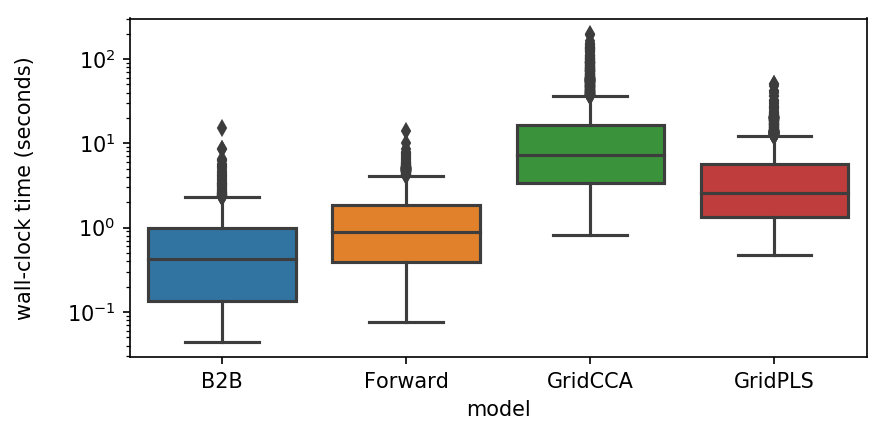

In [321]:
fig, axes = plt.subplots(1,1, figsize=(6,3), dpi=150)
ax = axes
sns.boxplot(y='duration', x='model', data=df.query('model!="Backward"'), ax=ax)
ax.set(yscale='log')
ax.set(ylabel='wall-clock time (seconds)\n')
fig.tight_layout()
plt.savefig('duration.pdf')

In [291]:
# sns.boxplot(y='r', x='model', data=df.query('model!="Backward"'))

In [292]:
# fig, ax = plt.subplots(figsize=(8,5))
# sns.boxplot(y='delta_auc', x='model', data=df, ax=ax)
# ax.axhline(color='k')
# ax.set(ylabel=('AUC - AUC_B2B'))

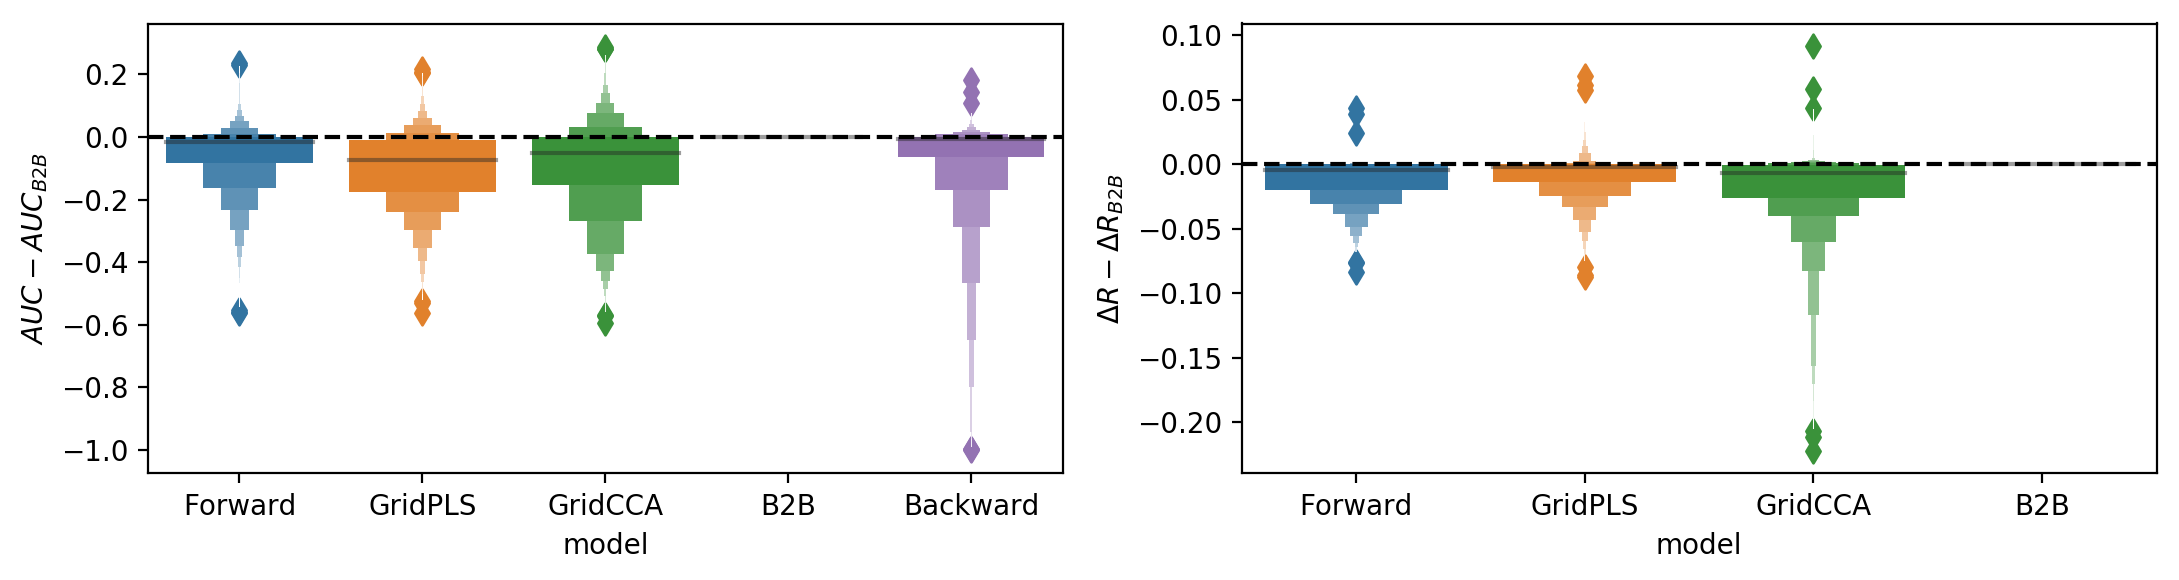

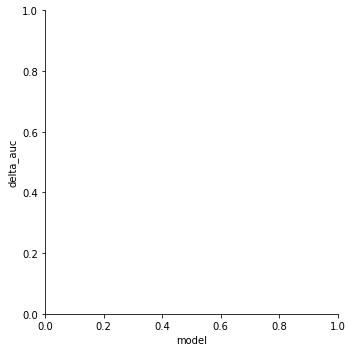

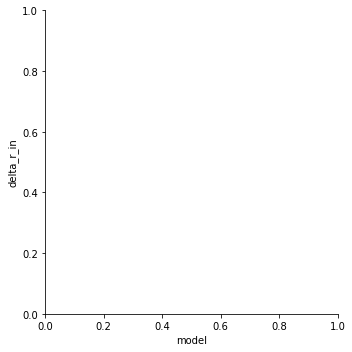

In [296]:
fig, axes = plt.subplots(1,2, figsize=(11,3), dpi=200)
ordering = ['Forward', 'GridPLS', 'GridCCA', 'B2B', 'Backward']

# sns.boxplot(y='auc', x='model', data=df, ax=ax)
# it_ax = iter(ax)
# ax=next(it_ax)
ax=axes[0]
sns.catplot(y='delta_auc', x='model', data=df, ax=ax, kind='boxen', order=ordering)
ax.axhline(color='k', linestyle='dashed')
ax.set(ylabel=(r'$AUC - AUC_{B2B}$'))

# ax=next(it_ax)
ax=axes[1]
sns.catplot(y='delta_r_in', x='model', data=df.query('model!="Backward"'), order=ordering[:-1], ax=ax, kind='boxen')
ax.axhline(color='k', linestyle='dashed')
ax.set(ylabel=(r'$\Delta R - \Delta R_{B2B}$'))
# ax.set(ylim=(-0.15, 0.35))
fig.tight_layout()
axes
plt.savefig('AUC_R.pdf')

In [263]:
# fig
#forward blue
#pls yellow
#cca green
#b2b red
#bwd purple

In [264]:
# sns.lineplot(y='r', x='snr', data=df.query('model!="Backward" and snr<10'), hue='model')
# set(xscale='log')


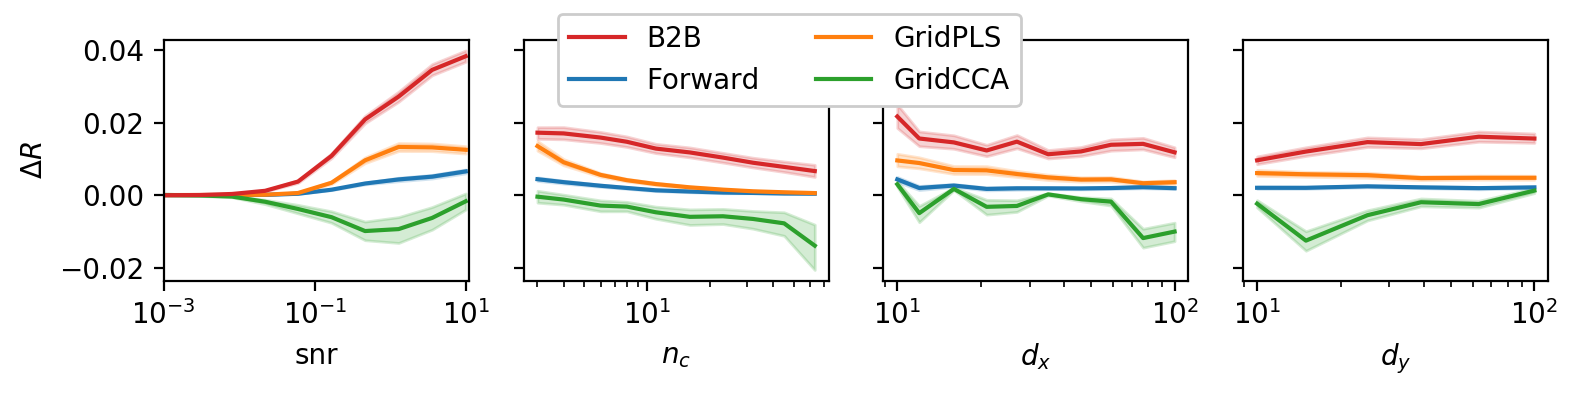

In [299]:
df['snr'] = df['snr'].round(3)
fig, axes = plt.subplots(1,4, figsize=(8,2), sharey=True, dpi=200)

ordering = ['Forward', 'GridPLS', 'GridCCA', 'B2B', 'Backward']

yplt = 'r_in'

# sns.catplot(y='delta_b2b', x='snr', data=df.query('model!="Backward"'), hue='model', aspect=3.5, jitter=0.3, ax=ax)
# ax=axes[0][0]
ax=axes[0]
# sns.lineplot(y='r', x='snr', data=df.query('model!="Backward" and snr<10'), hue='model', ax=ax, legend=False)
for modelname in ordering[:4]:
    sns.lineplot(y=yplt, x='snr', data=df.query(f'model=="{modelname}"'), ax=ax, legend=False)
ax.set(xscale='log')
ax.set(xlim=(1e-3, 11))
# ax.set(yscale='log')
ax.set(ylabel=(r'$\Delta R$'))

# ax=axes[1][0]
ax=axes[1]
# sns.lineplot(y='r', x='nc', data=df.query('model!="Backward" and snr<10'), hue='model', ax=ax)
for modelname in ordering[:4]:
    sns.lineplot(y=yplt, x='nc', data=df.query(f'model=="{modelname}"'), ax=ax, label=modelname)#, legend=False)
ax.set(xscale='log')
ax.legend(loc='upper right')
handles, labels = ax.get_legend_handles_labels()
ax.get_legend().remove()
new_handles = [handles[i] for i in [3,0,1,2]]
new_labels = [labels[i] for i in [3,0,1,2]]
fig.legend(new_handles, new_labels, loc='upper center', ncol=2, framealpha=1)
ax.set(xlabel=(r'$n_c$'))

# ax.set(yscale='log')

# ax=axes[0][1]
ax=axes[2]
# sns.lineplot(y='r', x='dim_x', data=df.query('model!="Backward" and snr<10'), hue='model', ax=ax, legend=False)
for modelname in ordering[:4]:
    sns.lineplot(y=yplt, x='dim_x', data=df.query(f'model=="{modelname}"'), ax=ax, legend=False)
ax.set(xscale='log')
# ax.set(yscale='log')
ax.set(xlabel=(r'$d_x$'))

# ax=axes[1][1]
ax=axes[3]
# sns.lineplot(y='r', x='dim_y', data=df.query('model!="Backward" and snr<10'), hue='model', ax=ax, legend=False)
for modelname in ordering[:4]:
    sns.lineplot(y=yplt, x='dim_y', data=df.query(f'model=="{modelname}"'), ax=ax, legend=False)
ax.set(xscale='log')
# ax.set(yscale='log')
ax.set(xlabel=(r'$d_y$'))

# handles, labels = ax.get_legend_handles_labels()
# ax.get_legend().remove()
# fig.legend(handles, labels, loc='upper center')

# lines = list()
# for i in range(4):
#     lines.append(ax.plot([0, 0], [0, .001], color='C%i' % i))
# fig.legend(lines, ['B2B', 'CCA', 'PLS', 'Forward'], loc='lower center', ncol=4)
fig.tight_layout()
plt.savefig('R_condition.pdf')

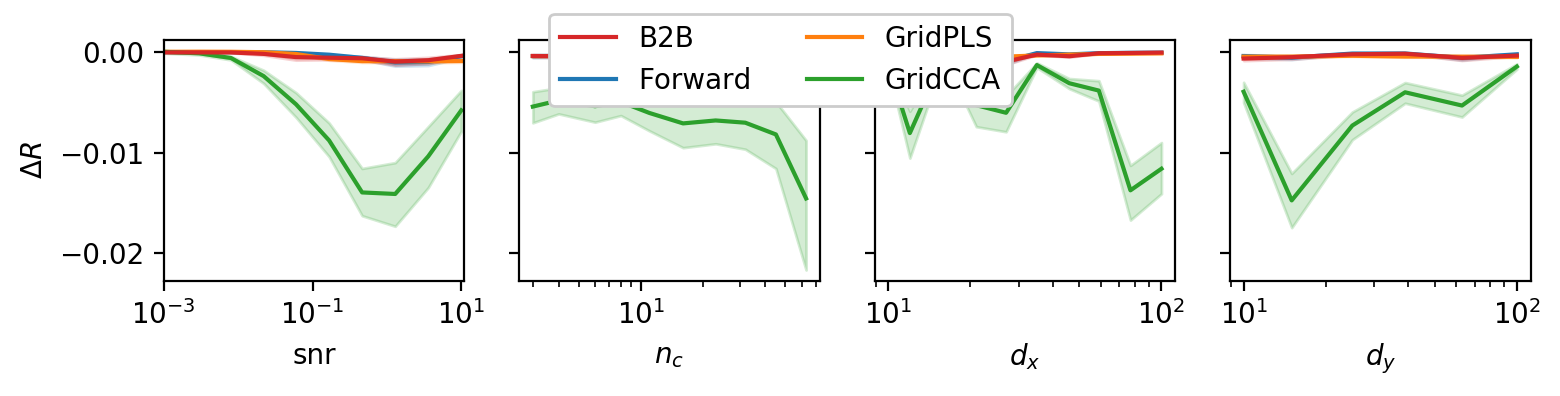

In [298]:
df['snr'] = df['snr'].round(3)
fig, axes = plt.subplots(1,4, figsize=(8,2), sharey=True, dpi=200)

ordering = ['Forward', 'GridPLS', 'GridCCA', 'B2B', 'Backward']

yplt = 'r_out'

# sns.catplot(y='delta_b2b', x='snr', data=df.query('model!="Backward"'), hue='model', aspect=3.5, jitter=0.3, ax=ax)
# ax=axes[0][0]
ax=axes[0]
# sns.lineplot(y='r', x='snr', data=df.query('model!="Backward" and snr<10'), hue='model', ax=ax, legend=False)
for modelname in ordering[:4]:
    sns.lineplot(y=yplt, x='snr', data=df.query(f'model=="{modelname}"'), ax=ax, legend=False)
ax.set(xscale='log')
ax.set(xlim=(1e-3, 11))
# ax.set(yscale='log')
ax.set(ylabel=(r'$\Delta R$'))

# ax=axes[1][0]
ax=axes[1]
# sns.lineplot(y='r', x='nc', data=df.query('model!="Backward" and snr<10'), hue='model', ax=ax)
for modelname in ordering[:4]:
    sns.lineplot(y=yplt, x='nc', data=df.query(f'model=="{modelname}"'), ax=ax, label=modelname)#, legend=False)
ax.set(xscale='log')
ax.legend(loc='upper right')
handles, labels = ax.get_legend_handles_labels()
ax.get_legend().remove()
new_handles = [handles[i] for i in [3,0,1,2]]
new_labels = [labels[i] for i in [3,0,1,2]]
fig.legend(new_handles, new_labels, loc='upper center', ncol=2, framealpha=1)
ax.set(xlabel=(r'$n_c$'))

# ax.set(yscale='log')

# ax=axes[0][1]
ax=axes[2]
# sns.lineplot(y='r', x='dim_x', data=df.query('model!="Backward" and snr<10'), hue='model', ax=ax, legend=False)
for modelname in ordering[:4]:
    sns.lineplot(y=yplt, x='dim_x', data=df.query(f'model=="{modelname}"'), ax=ax, legend=False)
ax.set(xscale='log')
# ax.set(yscale='log')
ax.set(xlabel=(r'$d_x$'))

# ax=axes[1][1]
ax=axes[3]
# sns.lineplot(y='r', x='dim_y', data=df.query('model!="Backward" and snr<10'), hue='model', ax=ax, legend=False)
for modelname in ordering[:4]:
    sns.lineplot(y=yplt, x='dim_y', data=df.query(f'model=="{modelname}"'), ax=ax, legend=False)
ax.set(xscale='log')
# ax.set(yscale='log')
ax.set(xlabel=(r'$d_y$'))

# handles, labels = ax.get_legend_handles_labels()
# ax.get_legend().remove()
# fig.legend(handles, labels, loc='upper center')

# lines = list()
# for i in range(4):
#     lines.append(ax.plot([0, 0], [0, .001], color='C%i' % i))
# fig.legend(lines, ['B2B', 'CCA', 'PLS', 'Forward'], loc='lower center', ncol=4)
fig.tight_layout()
plt.savefig('R_condition.pdf')

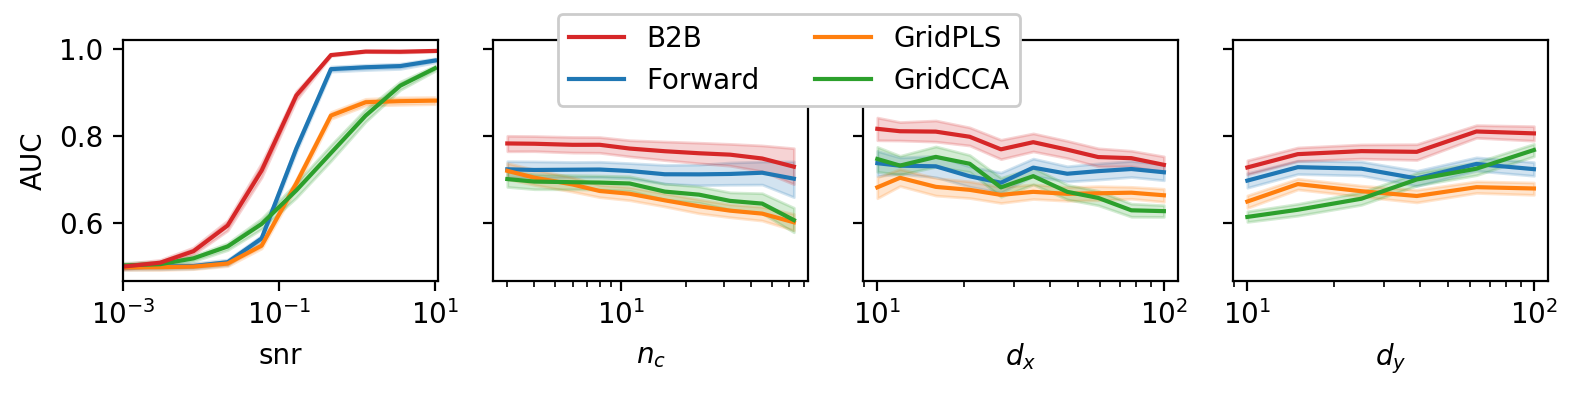

In [288]:
df['snr'] = df['snr'].round(3)
fig, axes = plt.subplots(1,4, figsize=(8,2), sharey=True, dpi=200)

ordering = ['Forward', 'GridPLS', 'GridCCA', 'B2B', 'Backward']


# sns.catplot(y='delta_b2b', x='snr', data=df.query('model!="Backward"'), hue='model', aspect=3.5, jitter=0.3, ax=ax)
# ax=axes[0][0]
ax=axes[0]
# sns.lineplot(y='r', x='snr', data=df.query('model!="Backward" and snr<10'), hue='model', ax=ax, legend=False)
for modelname in ordering[:4]:
    sns.lineplot(y='auc', x='snr', data=df.query(f'model=="{modelname}"'), ax=ax, legend=False)
ax.set(xscale='log')
ax.set(xlim=(1e-3, 11))
# ax.set(yscale='log')
ax.set(ylabel=('AUC'))

# ax=axes[1][0]
ax=axes[1]
# sns.lineplot(y='r', x='nc', data=df.query('model!="Backward" and snr<10'), hue='model', ax=ax)
for modelname in ordering[:4]:
    sns.lineplot(y='auc', x='nc', data=df.query(f'model=="{modelname}"'), ax=ax, label=modelname)#, legend=False)
ax.set(xscale='log')
ax.legend(loc='upper right')
handles, labels = ax.get_legend_handles_labels()
ax.get_legend().remove()
new_handles = [handles[i] for i in [3,0,1,2]]
new_labels = [labels[i] for i in [3,0,1,2]]
fig.legend(new_handles, new_labels, loc='upper center', ncol=2, framealpha=1)
ax.set(xlabel=(r'$n_c$'))

# ax.set(yscale='log')

# ax=axes[0][1]
ax=axes[2]
# sns.lineplot(y='r', x='dim_x', data=df.query('model!="Backward" and snr<10'), hue='model', ax=ax, legend=False)
for modelname in ordering[:4]:
    sns.lineplot(y='auc', x='dim_x', data=df.query(f'model=="{modelname}"'), ax=ax, legend=False)
ax.set(xscale='log')
# ax.set(yscale='log')
ax.set(xlabel=(r'$d_x$'))

# ax=axes[1][1]
ax=axes[3]
# sns.lineplot(y='r', x='dim_y', data=df.query('model!="Backward" and snr<10'), hue='model', ax=ax, legend=False)
for modelname in ordering[:4]:
    sns.lineplot(y='auc', x='dim_y', data=df.query(f'model=="{modelname}"'), ax=ax, legend=False)
ax.set(xscale='log')
# ax.set(yscale='log')
ax.set(xlabel=(r'$d_y$'))

# handles, labels = ax.get_legend_handles_labels()
# ax.get_legend().remove()
# fig.legend(handles, labels, loc='upper center')

# lines = list()
# for i in range(4):
#     lines.append(ax.plot([0, 0], [0, .001], color='C%i' % i))
# fig.legend(lines, ['B2B', 'CCA', 'PLS', 'Forward'], loc='lower center', ncol=4)
fig.tight_layout()
plt.savefig('AUC_condition.pdf')

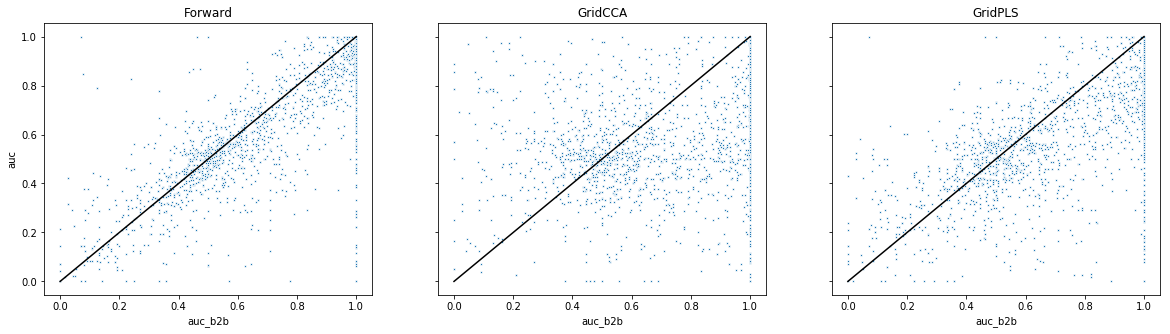

In [154]:
fig, axes = plt.subplots(1, 3, figsize=(20,5), sharex=True, sharey=True)
axes = iter(axes)
for m, data in df.groupby('model'):
    if m in ('Backward', 'B2B'): continue
    ax = next(axes)
    ax.plot([0, 1], [0, 1], color='k')
#     ax.axhline()
    ax.set_title(m)
    sns.scatterplot(y='auc', x='auc_b2b', data=data, ax=ax, s=5)

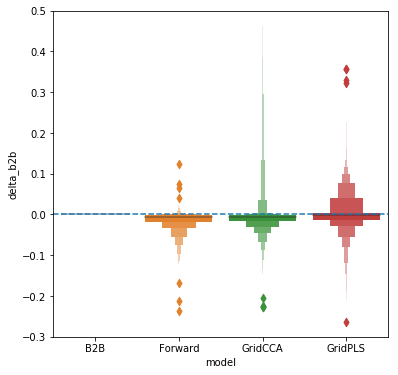

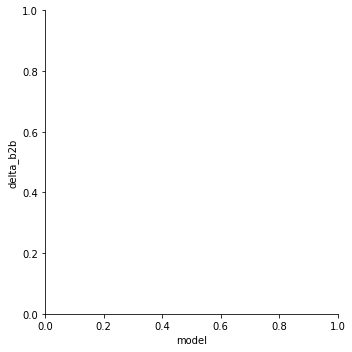

In [114]:
fig, ax = plt.subplots(figsize=(6,6))
sns.catplot(y='delta_b2b', x='model', data=df.query('model!="Backward"'), ax=ax, kind='boxen')
ax.set(ylim=(-0.3, 0.5))
ax.axhline(linestyle='dashed')
# ax.set(ylabel=('AUC'))


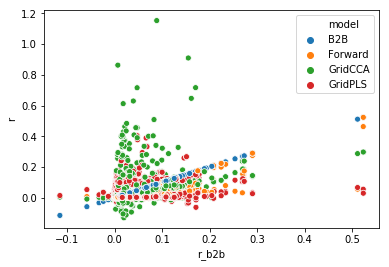

In [29]:
sns.scatterplot(y='r', x='r_b2b', data=df.query('model!="Backward"'), hue='model')

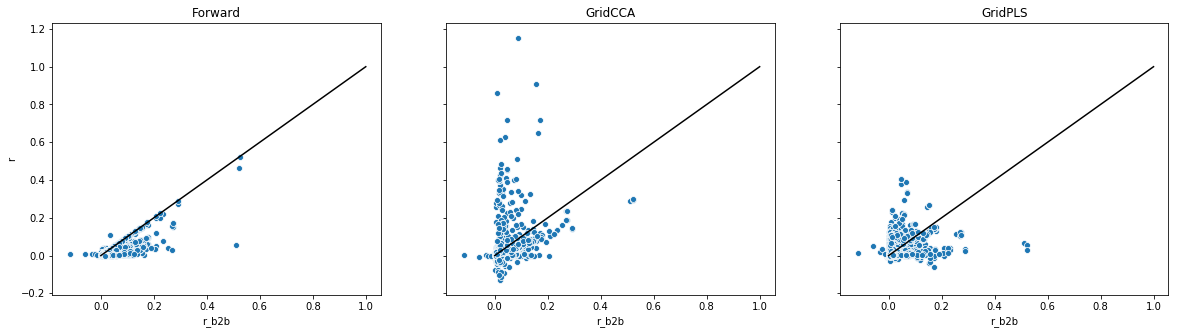

In [31]:
fig, axes = plt.subplots(1, 3, figsize=(20,5), sharex=True, sharey=True)
axes = iter(axes)
for m, data in df.groupby('model'):
    if m in ('Backward', 'B2B'): continue
    ax = next(axes)
    ax.plot([0, 1], [0, 1], color='k')
    ax.set_title(m)
    sns.scatterplot(y='r', x='r_b2b', data=data, ax=ax)

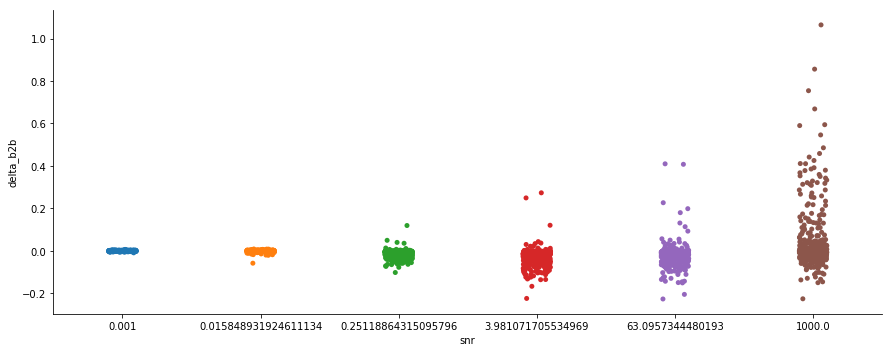

In [73]:
# sns.catplot(y='delta_b2b', x='snr', data=df.query('model!="Backward"'), hue='model')
sns.catplot(y='delta_b2b', x='snr', data=df.query('model=="GridCCA"'), aspect=2.5)

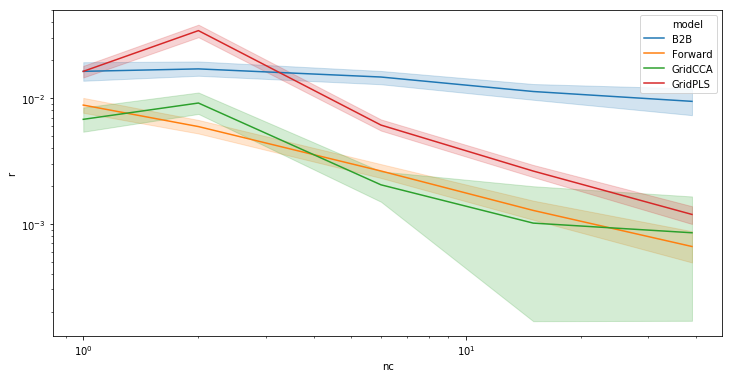

In [132]:
df['snr'] = df['snr'].round(3)
fig, ax = plt.subplots(figsize=(12,6))
# sns.catplot(y='delta_b2b', x='snr', data=df.query('model!="Backward"'), hue='model', aspect=3.5, jitter=0.3, ax=ax)
sns.lineplot(y='r', x='nc', data=df.query('model!="Backward" and snr<10'), hue='model', ax=ax)
ax.set(xscale='log')
ax.set(yscale='log')

ax.axhline(color='k')